# Pre-Lab 6
## Ian Eykamp

My group worked on the pre-lab together. Please see our code in the separate notebook titled `Lab6_prelab.ipynb`.

We used 8 and 7 turns of 22 AWG wire in a bifilar winding with a 0.007 inch air gap.

A couple notes on the process:
* We used the buck-boost equations without accounting for the transformer. In order to use the equations correctly, we should have applied the transformations to the load resistor and capacitor due to the transformer which we learned in Lesson 8b, $R_T = R_{load} \cdot (\frac{N_1}{N_2})^2$, $C_T = C_{load} \cdot (\frac{N_2}{N_1})^2$. According to other groups who performed the calculations, this would have shifted our target magnetizing inductance up to about 19uH, which is about the value of the transformer we used in Lab 5.
* Our target magnetizing inductance for the primary coil was 16.53uH. We calculated our gap length to be 14 thousandths of an inch. When we tested the inductance on the LCR meter, we obtained an inductance around a factor of two smaller than expected. We adjusted the gap length until we reached our magnetizing inductance empirically but were confused as to why the prediction was so far off.
* We used the same equivalent cross-sectional area that we had calculated for the ferrite-core inductor in Lab 4, in which we had about a 0.009 inch gap. However, the cross-sectional area is actually dependent on the gap length due to the boughing out of the magnetic field. This could have accounted for some of the error in our calculations, but probably not a factor of two.
* At the end of this lab report, I empirically calculate the magnetizing inductance $L$, turns ratio $a$, duty cycle, and critical inductance ratio $\alpha$, from the oscilloscope data for a 9V output. The measured values fall within the tolerance specified in the design requirements, particularly the $\alpha$ value, so we do not need to necessarily correct the short-cuts we took for the transformer calculations.

### Transformer Diagram
![Transformer diagram](transformer_diagram.jpg)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

Using matplotlib backend: <object object at 0x000001B1A5B31070>


C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Lab 6

## Oscilloscope Data

In [3]:
# Task 3 csv files: Vshunt and Vdrain
(df_4V_zoom1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile36.csv", ch1 = "Vsh_4V_zoom1", ch2 = "Vd_4V_zoom1")
(df_4V,       tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile37.csv", ch1 = "Vsh_4V", ch2 = "Vd_4V")
(df_7V,       tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile38.csv", ch1 = "Vsh_7V", ch2 = "Vd_7V")
(df_9V,       tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile39.csv", ch1 = "Vsh_9V", ch2 = "Vd_9V")
(df_9V_zoom1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile41.csv", ch1 = "Vsh_9V_zoom1", ch2 = "Vd_9V_zoom1")
(df_9V_zoom2, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile42.csv", ch1 = "Vsh_9V_zoom2", ch2 = "Vd_9V_zoom2")

# Combine all variables into one for convenience
# df = df_4V_zoom1.set_index("t").join([df_4V.set_index("t"), df_7V.set_index("t"), df_9V.set_index("t"), df_9V_zoom1.set_index("t"), df_9V_zoom2.set_index("t")]).reset_index()
df = df_4V.set_index("t").join([df_7V.set_index("t"), df_9V.set_index("t")]).reset_index()

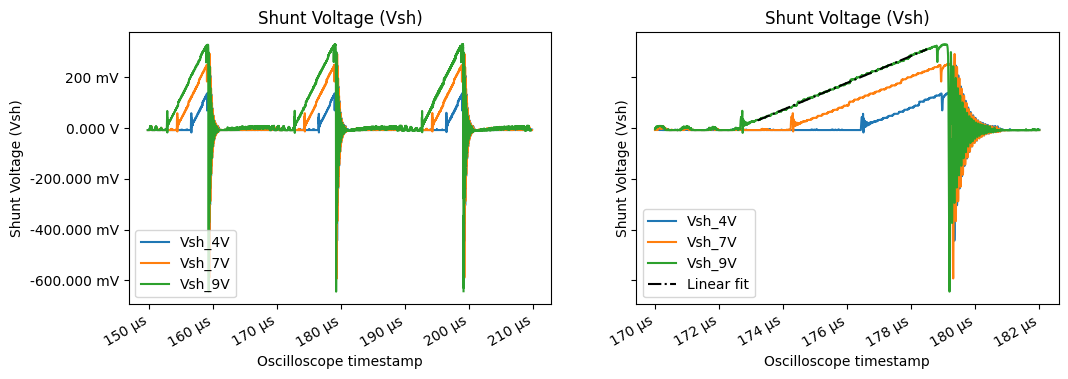

In [4]:
# Vshunt
df_envelope = df
df_zoom = df[(df["t"] > 170e-6) & (df["t"] < 182e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh)", ax = ax1)
ax1.plot(df_envelope["t"], df_envelope["Vsh_4V"], label = "Vsh_4V")
ax1.plot(df_envelope["t"], df_envelope["Vsh_7V"], label = "Vsh_7V")
ax1.plot(df_envelope["t"], df_envelope["Vsh_9V"], label = "Vsh_9V")
ax1.legend(loc = "lower left")

helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh)", ax = ax2)
ax2.plot(df_zoom["t"], df_zoom["Vsh_4V"], label = "Vsh_4V")
ax2.plot(df_zoom["t"], df_zoom["Vsh_7V"], label = "Vsh_7V")
ax2.plot(df_zoom["t"], df_zoom["Vsh_9V"], label = "Vsh_9V")

Vshunt = np.array([150e-3, 260e-3, 330e-3])
# ax2.axhline(y = Vshunt[0], color = "black", linestyle = "dashed", label = f"Vsh = {int(Vshunt[0] * 1e3)}mV")
# ax2.axhline(y = Vshunt[1], color = "black", linestyle = "dashed", label = f"Vsh = {int(Vshunt[1] * 1e3)}mV")
# ax2.axhline(y = Vshunt[2], color = "black", linestyle = "dashed", label = f"Vsh = {int(Vshunt[2] * 1e3)}mV")
ax2.legend(loc = "lower left")

# plot duty cycle markers
duty_cycle_ts = [(159e-6, 176.2e-6, 179e-6), (159e-6, 174e-6, 179e-6), (159e-6, 172.5e-6, 179e-6)]
for duty_cycle_marker_set in duty_cycle_ts:
    # print(duty_cycle_marker_set)
    for duty_cycle_marker in duty_cycle_marker_set:
        # ax1.axvline(x = duty_cycle_marker, linestyle = "dashed", color = "grey")
        pass

linear_ts = (173.2e-6, 178.5e-6)
df_linreg = df_9V[(df_9V["t"] > linear_ts[0]) & (df_9V["t"] < linear_ts[1])]

x = df_linreg["t"]
y = df_linreg["Vsh_9V"]
A = np.vstack([x, np.ones(len(x))]).T
a, b = np.linalg.lstsq(A, y, rcond=None)[0]
ax2.plot(df_linreg["t"], df_linreg["t"] * a + b, linestyle = "dashdot", color = "black", label = "Linear fit")
ax2.legend(loc = "lower left")

The traces look very similar to those obtained in Lab 5. The current changes slightly more quickly due to the smaller magnetizing inductance (~17uH vs. ~19uH).

In [5]:
duty_cycle_list = []
for i, duty_cycle_marker_set in enumerate(duty_cycle_ts):
    this_duty_cycle = 1 - (duty_cycle_marker_set[1] - duty_cycle_marker_set[0]) / ((duty_cycle_marker_set[2] - duty_cycle_marker_set[0]))
    duty_cycle_list.append(this_duty_cycle)

duty_cycle = np.array(duty_cycle_list)
# print(f"Duty cycle for 9V output: {(duty_cycle * 100).round(1)}%")

Rload = 5 # ohms
Rshunt = 0.05 # ohms
Vin = 17.97 # V
Vout = 9.02 # V
dIdt = a / Rshunt
Vinductor = Vin # minus
L = Vinductor / dIdt
print(f"L: {si_format(L, precision = 2)}H")
# print(f"dI/dt: {si_format(dIdt, precision = 2)}A/s")

output_voltage = np.array([4.01, 7.00, 9.00]) # V
output_current = output_voltage / Rload
input_current = np.array([0.28, 0.77, 1.25]) # A
power_efficiency = (output_voltage * output_current) / (Vin * input_current)
df_to_print = pd.DataFrame({"Output Voltage (V)": output_voltage, "Input Current (A)": input_current, 
              "Vshunt (V)": Vshunt, "I_peak (A)": Vshunt / Rshunt, 
              "duty cycle (%)": (duty_cycle * 100).round(1), "efficiency (%)": (power_efficiency * 100).round(1)})
df_to_print.set_index("Output Voltage (V)", inplace = True)
print(df_to_print)


L: 16.96 µH
                    Input Current (A)  Vshunt (V)  I_peak (A)  duty cycle (%)  \
Output Voltage (V)                                                              
4.01                             0.28        0.15         3.0            14.0   
7.00                             0.77        0.26         5.2            25.0   
9.00                             1.25        0.33         6.6            32.5   

                    efficiency (%)  
Output Voltage (V)                  
4.01                          63.9  
7.00                          70.8  
9.00                          72.1  


The magnetizing inductance of the transformer is ~16.9uH. The efficiency is 65%-75%, voltage-dependent, similar to Lab 5. The duty cycle is comparable though slightly shorter than for the Lab 5 transformer. This is because the magnetizing inductance is smaller, causing the inductor current to reach `I_peak` faster.

## MOSFET Drain Voltage Plots

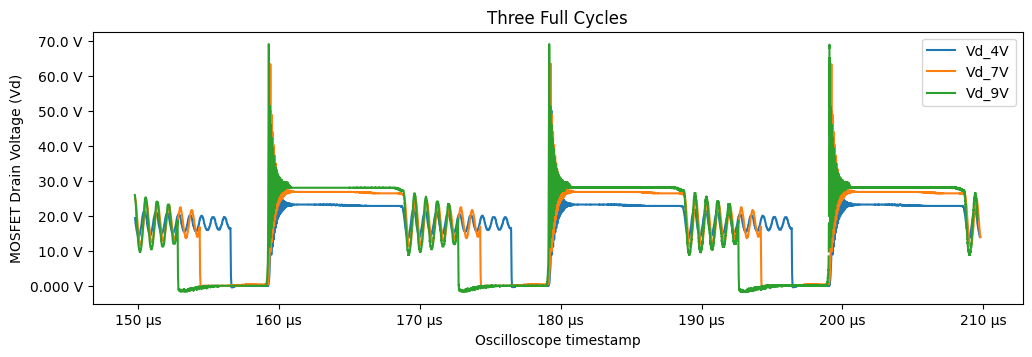

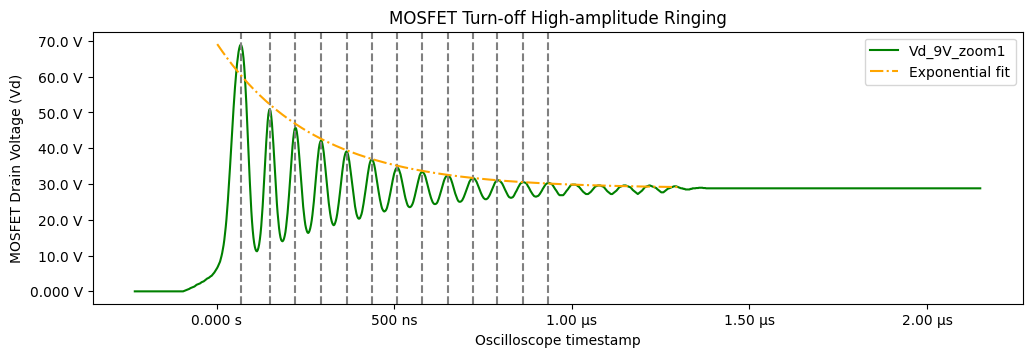

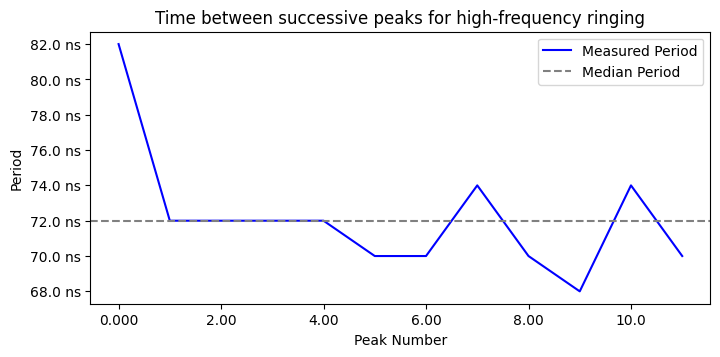

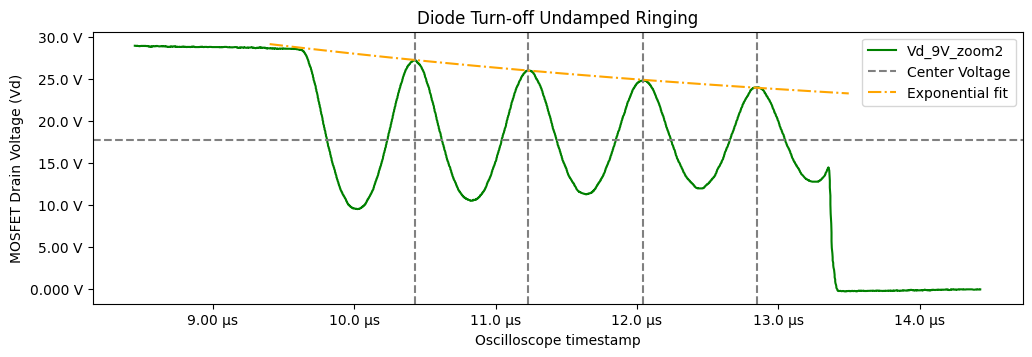

In [70]:
# Plot Vdrain
fig = plt.figure(figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = "Three Full Cycles")
plt.plot(df["t"], df["Vd_4V"], label = "Vd_4V")
plt.plot(df["t"], df["Vd_7V"], label = "Vd_7V")
plt.plot(df["t"], df["Vd_9V"], label = "Vd_9V")
# Vdrain = np.array([36, 42, 47]) # Lab 5 values
Vdrain = np.array([23.3, 26.9, 28.1])
# plt.axhline(y = Vdrain[0], color = "black", linestyle = "dashed", label = f"Vdr = {int(Vdrain[0])}V")
# plt.axhline(y = Vdrain[1], color = "black", linestyle = "dashed", label = f"Vdr = {int(Vdrain[1])}V")
# plt.axhline(y = Vdrain[2], color = "black", linestyle = "dashed", label = f"Vdr = {int(Vdrain[2])}V")
plt.legend(loc = "upper right")


# Vdrain high frequency ringing
fig = plt.figure(figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = "MOSFET Turn-off High-amplitude Ringing")
plt.plot(df_9V_zoom1["t"], df_9V_zoom1["Vd_9V_zoom1"], color = "green", label = "Vd_9V_zoom1")
plt.legend(loc = "upper right")

# Equilibrium voltage
plateau_ts = (1.5e-6, 2e-6)
df_plateau = df_9V_zoom1[(df_9V_zoom1["t"] > plateau_ts[0]) & (df_9V_zoom1["t"] < plateau_ts[1])]
plateau_height = np.mean(df_plateau["Vd_9V_zoom1"])

exp_fit_ts = (0, 1.3e-6)
df_exp_fit = df_9V_zoom1[(df_9V_zoom1["t"] > exp_fit_ts[0]) & (df_9V_zoom1["t"] < exp_fit_ts[1])]

high_freq_peak_times = []
high_freq_peak_heights = []
high_freq_peaks, _ = find_peaks(df_9V_zoom1["Vd_9V_zoom1"], prominence=3)
for peak in high_freq_peaks:
    peak_time = df_9V_zoom1["t"][peak]
    peak_height = df_9V_zoom1["Vd_9V_zoom1"][peak]
    high_freq_peak_times.append(peak_time)
    high_freq_peak_heights.append(peak_height)
    plt.axvline(x = peak_time, linestyle = "dashed", color = "grey")
high_freq_peak_diffs = np.diff(high_freq_peak_times)
high_freq_period = np.median(high_freq_peak_diffs)

high_freq_peak_heights = np.array(high_freq_peak_heights)

x = high_freq_peak_times
y = np.log(high_freq_peak_heights - plateau_height)
A = np.vstack([x, np.ones(len(x))]).T
a, b = np.linalg.lstsq(A, y, rcond=None)[0]
plt.plot(df_exp_fit["t"], np.exp(df_exp_fit["t"] * a + b) + plateau_height, linestyle = "dashdot", color = "orange", label = "Exponential fit")
plt.legend(loc = "upper right")

high_freq_decay_factor = a

# Peak positions
fig = plt.figure(figsize = (8, 4))
fig.autofmt_xdate()
helper.axes_labels("Peak Number", "", "Period", "s", title = "Time between successive peaks for high-frequency ringing")
plt.plot(range(len(high_freq_peak_diffs)), high_freq_peak_diffs, color = "blue", label = "Measured Period")
plt.axhline(y = high_freq_period, linestyle = "dashed", color = "grey", label = "Median Period")
plt.legend(loc = "upper right")

# Vdrain low frequency ringing
center_height = 17.8 # V
fig = plt.figure(figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = "Diode Turn-off Undamped Ringing")
plt.plot(df_9V_zoom2["t"], df_9V_zoom2["Vd_9V_zoom2"], color = "green", label = "Vd_9V_zoom2")
plt.axhline(y = center_height, linestyle = "dashed", color = "grey", label = "Center Voltage")
plt.legend(loc = "upper right")

exp_fit_ts = (9.4e-6, 13.5e-6)
df_exp_fit = df_9V_zoom2[(df_9V_zoom2["t"] > exp_fit_ts[0]) & (df_9V_zoom2["t"] < exp_fit_ts[1])]

low_freq_peak_times = []
low_freq_peak_heights = []
low_freq_peaks, _ = find_peaks(df_9V_zoom2["Vd_9V_zoom2"], prominence = 5, distance = 10)
low_freq_peaks[2] = low_freq_peaks[2] - 5

for peak in low_freq_peaks:
    peak_time = df_9V_zoom2["t"][peak]
    low_freq_peak_times.append(peak_time)
    plt.axvline(x = peak_time, linestyle = "dashed", color = "grey")
    peak_height = df_9V_zoom2["Vd_9V_zoom2"][peak]
    low_freq_peak_heights.append(peak_height)
low_freq_peak_diffs = np.diff(low_freq_peak_times)
low_freq_period = np.median(low_freq_peak_diffs)

low_freq_peak_heights = np.array(low_freq_peak_heights)

x = low_freq_peak_times
y = np.log(low_freq_peak_heights - center_height)
A = np.vstack([x, np.ones(len(x))]).T
a, b = np.linalg.lstsq(A, y, rcond=None)[0]
plt.plot(df_exp_fit["t"], np.exp(df_exp_fit["t"] * a + b) + center_height, linestyle = "dashdot", color = "orange", label = "Exponential fit")
plt.legend(loc = "upper right")

low_freq_decay_factor = a

high_freq_nat_freq = 2 * np.pi / high_freq_period
low_freq_nat_freq = 2 * np.pi / low_freq_period
high_freq_time_constant = 1 / high_freq_decay_factor
low_freq_time_constant = 1 / low_freq_decay_factor

## Interpretation
The peak and plateau drain voltages are much smaller than they were for the Lab 5 transformer, probably due to the lower magnetizing inductance. Here, the drain voltages are 23V, 27V, and 28V for the plateau and 60-70V for the highest peak. For comparison, the Lab 5 values were 36V, 42V, and 47V for the plateau and 100-125V for the highest peak. The lower peak voltage is a benefit of our transformer over the Lab 5 transformer.

The time constants and frequencies of oscillation are printed out below. They seem to make sense from the graphs and match with my estimations from Lab 5. The exponential fit matches well for all peaks except the first one or two high-frequency rings, as expected. The period settles to a consistent value after the first two peaks.

In [7]:
# Print values
print(f"Plateau drain voltages (4V, 7V, 9V outputs): {Vdrain}")
print("---")
# print(f"High-frequency ringing period: {si_format(high_freq_period, precision = 0)}s")
# print(f"Low-frequency ringing period: {si_format(low_freq_period, precision = 0)}s")
# print(f"High-frequency decay rate: {si_format(high_freq_period, precision = 0)}Hz")
# print(f"Low-frequency decay rate: {si_format(low_freq_period, precision = 0)}Hz")
print(f"High-frequency damped natural frequency: {si_format(high_freq_nat_freq, precision = 1)}rad/s")
print(f"Low-frequency damped natural frequency: {si_format(low_freq_nat_freq, precision = 2)}rad/s")
print(f"High-frequency time constant: {si_format(high_freq_time_constant, precision = 0)}s")
print(f"Low-frequency time constant: {si_format(low_freq_time_constant, precision = 2)}s")

Plateau drain voltages (4V, 7V, 9V outputs): [23.3 26.9 28.1]
---
High-frequency damped natural frequency: 87.3 Mrad/s
Low-frequency damped natural frequency: 7.80 Mrad/s
High-frequency time constant: -273 ns
Low-frequency time constant: -5.64 µs


In [8]:
Rload = 5 # Ohm

a_formula = []
a_ratio = []
alphas = []
for i, duty_cycle_marker_set in enumerate(duty_cycle_ts):
    Ts = duty_cycle_marker_set[2] - duty_cycle_marker_set[0]
    Fs = 1 / Ts

    M = output_voltage[i] / Vin
    Lcrit = 1 / (M + 1) ** 2 * Rload * Ts / 2
    alpha = L / Lcrit
    D = duty_cycle[i]
    Vout = output_voltage[i]
    a = Vin / Vout * D / (np.sqrt(alpha) - D)
    # print(f"M: {M}, alpha: {alpha}, D: {D}, Vin: {Vin}, Vout: {Vout}, Ts: {Ts}, a:{a}")
    a_formula.append(a)
    alphas.append(alpha)

    Vleft = Vin - Vdrain[i]
    Vright = output_voltage[i]
    a_ratio.append(-Vleft / Vright)
    # print(f"Vin: {Vin}, Vdrain: {Vdrain[i]}, output_voltage: {output_voltage[i]}, Vleft: {Vleft}, Vright: {Vright}, a:{a_ratio}")
    
df_to_print = pd.DataFrame({"Output Voltage (V)": output_voltage, "Vdrain (V)": Vdrain, "a (voltage ratio)": a_ratio, 
                            "Duty cycle (calculated above)": duty_cycle, "a (formula)": a_formula, "alpha": alphas})
df_to_print.set_index("Output Voltage (V)", inplace = True)
print(df_to_print)

                    Vdrain (V)  a (voltage ratio)  \
Output Voltage (V)                                  
4.01                      23.3           1.329177   
7.00                      26.9           1.275714   
9.00                      28.1           1.125556   

                    Duty cycle (calculated above)  a (formula)     alpha  
Output Voltage (V)                                                        
4.01                                        0.140     1.096168  0.507429  
7.00                                        0.250     1.147599  0.654873  
9.00                                        0.325     1.181870  0.763980  


The experimental turns ratio is about 1.16, very close to the desired value calculated in the pre-lab.
The alpha value is significantly lower than the spec for output voltages below 9V. However, the alpha value is strongly dependent on and increases with the output voltage, and the spec required an alpha value >70% only for an output voltage of 10V. Therefore, I am confident that we have met the spec for a 10V output, since alpha is already greater than 70% for the 9V output.

## Capacitance Calculations

The leakage inductances were measured on the LCR meter by shorting together the leads of the coil not hooked up to the meter. The flux that is coupled between the windings drives a small current in the secondary coil, which dissipates the energy, thus not allowing the coupled (magnetizing) inductance to be read by the meter.

The equations from Lesson 9a were used to calculate the parasitic resistance and capacitance for the MOSFET turn-off (high frequency ringing) configuration. The equivalent resistance and capacitance are on the order to be expected from a PCB circuit but still suspicious. For example, the [datasheet](https://www.mouser.com/datasheet/2/149/FDP120N10-96113.pdf) for the MOSFET lists the terminal capacitances of hundreds of pF and an on resistance in the milliohms. In any case, plugging the values back into the damped second-order system model gives an almost perfect match with the measured high-frequency waveform after the first few peaks.

L_high_freq: 1.65 µH
C: 79.64 pF
R: 12.06 Ohm


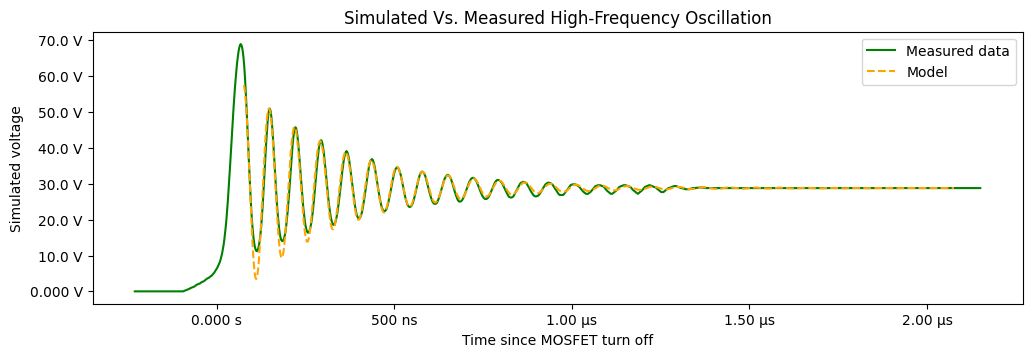

In [69]:
def parallel(x, y):
    return 1 / (1 / x + 1 / y)

wd = high_freq_nat_freq
beta = 1 # approximate
w0 = wd / beta
alpha = -high_freq_decay_factor
zeta = alpha / w0
L2 = 0.61e-6 # Leakage inductance 1, uH
L1 = 1.06e-6 # Leakage inductance 2, uH
L_high_freq = parallel(L, L2) + L1
C = (1 / w0) ** 2 / L_high_freq
R = 2 * alpha * L_high_freq

print(f"L_high_freq: {si_format(L_high_freq, precision = 2)}H")
print(f"C: {si_format(C, precision = 2)}F")
print(f"R: {si_format(R, precision = 2)}Ohm")

sim_t = np.arange(0, 2e-6, 1e-9)
sim_V = plateau_height * (1 - 1 / beta * np.exp(-alpha * sim_t) * np.sin(w0 * beta * sim_t - 1.5))

# Vdrain high frequency ringing
fig = plt.figure(figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Time since MOSFET turn off", "s", "Simulated voltage", "V", title = "Simulated Vs. Measured High-Frequency Oscillation")
plt.plot(df_9V_zoom1["t"], df_9V_zoom1["Vd_9V_zoom1"], color = "green", label = "Measured data")
plt.plot(sim_t+77e-9, sim_V, color = "orange", linestyle = "dashed", label = "Model")
plt.legend(loc = "upper right")

## PLECS Model

I inserted my values into the model below. When I plugged in the values calculated above, the model oscillated continuously and failed to converge with my control loop. I adjusted the parasitic capacitance and MOSFET on resistance until they reached the right order of magnitude, as shown below. My final PLECS model behaves qualitatively similarly to the measured waveforms for the MOSFET drain voltage.

![PLECS Schematic using adjusted Rds_on and C_parasitic values](adjusted_values_yellow_background.png)